In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark as ps
import scipy.stats as stats
import sys
sys.path.append("..")
from src.support_functions import fixing_datetime

plt.style.use('ggplot')

## Loading Dataset into Pandas DateFrame for Turnstile Datasets

In [2]:
turnstile2019_df = pd.read_csv('../data/Turnstile_Usage_Data__2019.csv', low_memory=False)
turnstile2020_df = pd.read_csv('../data/Turnstile_Usage_Data__2020.csv', low_memory=False)

In [3]:
turnstile2019_df.columns = [column.strip() for column in turnstile2019_df.columns]
turnstile2020_df.columns = [column.strip() for column in turnstile2019_df.columns]

In [4]:
turnstile2019_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A033,R170,02-06-00,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,769115,559221
1,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,6483080,4945335
2,A033,R170,02-00-03,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,7191422,8417203
3,A033,R170,02-00-02,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,14983900,14554087
4,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,12/27/2019,00:00:00,REGULAR,71047673,20925389


In [5]:
turnstile2020_df.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2020,00:00:00,REGULAR,7476781,2544029
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2020,04:00:00,REGULAR,7476785,2544030
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2020,08:00:00,REGULAR,7476802,2544088
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2020,12:00:00,REGULAR,7476847,2544188
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,10/23/2020,16:00:00,REGULAR,7477040,2544233


## Fixing DateTime

In [6]:
# turnstile2019_df['Date'] = pd.to_datetime(turnstile2019_df.Date)
# turnstile2020_df['Date'] = pd.to_datetime(turnstile2020_df.Date)

In [7]:
# turnstile2020_df.head()

In [8]:
# df['Date'] = df.YR.astype(str) + '-' + df.MN.astype(str) + '-' + df.DAY.astype(str)  
# df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')

# start_date = '2018-07-20'
# end_date = '2019-08-10'
# mask = (df['Date'] > start_date) & (df['Date'] <= end_date)
# df_18_19 = df.loc[mask]
# daily_18_19 = df_18_19.groupby(['Date']).mean()

In [9]:
# start_date = '2020-03-01'
# end_date = '2020-09-30'
# date_range = (turnstile2020_df['Date'] >= start_date) & (turnstile2020_df['Date'] <= end_date)
# ts_df_2020 = turnstile2020_df.loc[date_range]

In [10]:
# start_date = '2019-03-01'
# end_date = '2019-09-30'
# date_range = (turnstile2019_df['Date'] >= start_date) & (turnstile2019_df['Date'] <= end_date)
# ts_df_2019 = turnstile2019_df.loc[date_range]

In [11]:
ts_df_2019 = fixing_datetime(turnstile2019_df)

In [12]:
ts_df_2020 = fixing_datetime(turnstile2020_df)

## Cleaning up Duplicates

In [13]:
(turnstile2019_df
 .groupby(["C/A", "Unit", "SCP", "Station", "Date", "Time"])  
 .Entries.count()
 .reset_index()  # or use as_index = False; otherwise makes groupby columns new index 
 .sort_values("Entries", ascending=False)).head(5)

,C/A,Unit,SCP,Station,Date,Time,Entries
6249589,R101,R001,02-00-04,SOUTH FERRY,2019-09-17,05:00:00,4
6255921,R101,R001,02-00-07,SOUTH FERRY,2019-09-17,05:00:00,4
7868251,R242,R049,01-00-03,51 ST,2019-10-12,20:00:00,2
1729077,H035,R348,00-00-01,ATLANTIC AV,2019-10-18,20:00:00,2
7868246,R242,R049,01-00-03,51 ST,2019-10-12,00:00:00,2


In [14]:
(turnstile2020_df
 .groupby(["C/A", "Unit", "SCP", "Station", "Date", "Time"])  
 .Entries.count()
 .reset_index()  # or use as_index = False; otherwise makes groupby columns new index 
 .sort_values("Entries", ascending=False)).head(5)

,C/A,Unit,SCP,Station,Date,Time,Entries
7158932,R315,R406,01-00-00,PROSPECT AV,2020-10-03,13:00:00,4
449066,A060,R001,00-00-00,WHITEHALL S-FRY,2020-08-01,13:00:00,4
450851,A060,R001,00-00-01,WHITEHALL S-FRY,2020-08-01,13:00:00,4
1642240,J023,R436,00-00-00,NORWOOD AV,2020-08-25,05:00:00,4
1354572,H009,R235,00-03-00,BEDFORD AV,2020-03-22,12:00:00,4


In [15]:
turnstile2019_df.Description.value_counts()

REGULAR       10421447
RECOVR AUD       45654
Name: Description, dtype: int64

In [16]:
turnstile2020_df.Description.value_counts()

REGULAR       11166589
RECOVR AUD       43674
Name: Description, dtype: int64

In [17]:
# Get rid of the duplicate entry
turnstile2019_df.sort_values(["C/A", "Unit", "SCP", "Station", "Date", "Time"], inplace=True, ascending=False)
turnstile2019_df.drop_duplicates(subset=["C/A", "Unit", "SCP", "Station", "Date", "Time"], inplace=True)

In [18]:
# Get rid of the duplicate entry
turnstile2020_df.sort_values(["C/A", "Unit", "SCP", "Station", "Date", "Time"], inplace=True, ascending=False)
turnstile2020_df.drop_duplicates(subset=["C/A", "Unit", "SCP", "Station", "Date", "Time"], inplace=True)

In [19]:
(turnstile2019_df
 .groupby(["C/A", "Unit", "SCP", "Station", "Date", "Time"])
 .Entries.count()
 .reset_index()
 .sort_values("Entries", ascending=False)).head(5)

,C/A,Unit,SCP,Station,Date,Time,Entries
0,A002,R051,02-00-00,59 ST,2018-12-29,03:00:00,1
6703423,R139,R031,04-00-00,34 ST-PENN STA,2019-09-01,16:00:00,1
6703416,R139,R031,04-00-00,34 ST-PENN STA,2019-08-31,12:00:00,1
6703417,R139,R031,04-00-00,34 ST-PENN STA,2019-08-31,16:00:00,1
6703418,R139,R031,04-00-00,34 ST-PENN STA,2019-08-31,20:00:00,1


In [20]:
(turnstile2020_df
 .groupby(["C/A", "Unit", "SCP", "Station", "Date", "Time"])
 .Entries.count()
 .reset_index()
 .sort_values("Entries", ascending=False)).head(5)

,C/A,Unit,SCP,Station,Date,Time,Entries
0,A002,R051,02-00-00,59 ST,2019-12-28,03:00:00,1
5669270,R138,R293,00-03-04,34 ST-PENN STA,2020-04-14,14:00:00,1
5669300,R138,R293,00-03-04,34 ST-PENN STA,2020-04-19,14:00:00,1
5669299,R138,R293,00-03-04,34 ST-PENN STA,2020-04-19,10:00:00,1
5669298,R138,R293,00-03-04,34 ST-PENN STA,2020-04-19,06:00:00,1


In [21]:
turnstile2019_df = turnstile2019_df.drop(["Exits", "Description"], axis=1, errors="ignore")

In [22]:
turnstile2020_df = turnstile2020_df.drop(["Exits", "Description"], axis=1, errors="ignore")

## Grouping by Date, Unit(station), SCP(turnstile) for 2019

In [23]:
gb2019 = ts_df_2019[['Station', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Station', 'SCP']).agg([min, max])

In [24]:
gb2019.reset_index()

Date    Station       SCP    Entries           
                                              min        max
0      2019-03-02       1 AV  00-00-00   14471608   14471608
1      2019-03-02       1 AV  00-00-01   59965923   59965923
2      2019-03-02       1 AV  00-03-00  370591205  370591205
3      2019-03-02       1 AV  00-03-01    2395009    2395009
4      2019-03-02       1 AV  00-03-02    6299900    6299900
...           ...        ...       ...        ...        ...
854900 2019-09-30  ZEREGA AV  00-00-01     150377     150643
854901 2019-09-30  ZEREGA AV  00-03-00     984114     984742
854902 2019-09-30  ZEREGA AV  00-03-01     925487     926586
854903 2019-09-30  ZEREGA AV  00-05-00        214        214
854904 2019-09-30  ZEREGA AV  00-05-01         39         39

[854905 rows x 5 columns]

In [25]:
gb2019.columns


MultiIndex([('Entries', 'min'),
            ('Entries', 'max')],
           )

In [26]:
gb2019['Total'] = gb2019[('Entries', 'max')] - gb2019[('Entries', 'min')]
gb2019.drop(gb2019[gb2019['Total'] < 10].index, inplace=True)
gb2019.drop(gb2019[gb2019['Total'] > 10000].index, inplace=True)

In [27]:
gb2019.sort_values(['Total'], ascending=False)

Entries            Total
                                          min       max       
Date       Station         SCP                                
2019-05-16 GRD CNTRL-42 ST 02-00-04   2534354   2544354  10000
2019-07-19 CANAL ST        01-00-02   1399978   1409917   9939
2019-09-25 PROSPECT AV     01-00-00   1002116   1012054   9938
2019-09-03 THIRTY ST       00-04-04        10      9935   9925
2019-06-10 GROVE STREET    00-01-05        86      9891   9805
...                                       ...       ...    ...
2019-05-05 NEWARK C        02-01-00    155969    155979     10
2019-04-12 59 ST COLUMBUS  01-05-00  50344121  50344131     10
2019-03-24 CITY / BUS      00-01-01    550290    550300     10
2019-09-08 EXCHANGE PLACE  00-04-00     14847     14857     10
2019-08-28 104 ST          00-06-00   5606990   5607000     10

[650413 rows x 3 columns]

In [28]:
#data.groupby(level=[0, 1]).sum()
sum_per_station_2019 = gb2019.groupby(level=[0, 1]).sum()
sum_per_station_2019

Entries              Total
                                   min         max       
Date       Station                                       
2019-03-02 103 ST-CORONA      69975630    69988969  13339
           104 ST           1691331838  1691332480    642
           110 ST             37094334    37100277   5943
           111 ST             10171852    10175021   3169
           116 ST              2804920     2809171   4251
...                                ...         ...    ...
2019-09-30 WOODLAWN           31268329    31274228   5899
           WORLD TRADE CTR  1598440395  1598456567  16172
           WTC-CORTLANDT     735073838   735086425  12587
           YORK ST            43932944    43944200  11256
           ZEREGA AV           2140313     2142606   2293

[73107 rows x 3 columns]

In [29]:
sum_per_date_2019 = sum_per_station_2019.groupby(level=[0]).sum()
sum_per_date_2019

Entries                  Total
                     min           max         
Date                                           
2019-03-02  109827717071  109829651510  1934439
2019-03-03  110528979381  110530550419  1571038
2019-03-04  116919228678  116922489017  3260339
2019-03-05  116987967515  116992312579  4345064
2019-03-06  118919396096  118923713485  4317389
...                  ...           ...      ...
2019-09-26  128542556872  128546991344  4434472
2019-09-27  128539501363  128543756900  4255537
2019-09-28  116465658630  116467816581  2157951
2019-09-29  112094548802  112096288867  1740065
2019-09-30  127905951640  127909545182  3593542

[199 rows x 3 columns]

In [30]:
len(sum_per_station_2019)

73107

In [31]:
gb2019.columns

MultiIndex([('Entries', 'min'),
            ('Entries', 'max'),
            (  'Total',    '')],
           )

## Grouping by Date, Unit(station), SCP(turnstile) for 2020

In [32]:
gb2020 = ts_df_2020[['Station', 'SCP', 'Date', 'Entries']].groupby(['Date', 'Station', 'SCP']).agg([min, max])

In [33]:
gb2020['Total'] = gb2020[('Entries', 'max')] - gb2020[('Entries', 'min')]
gb2020.drop(gb2020[gb2020['Total'] < 10].index, inplace=True)
gb2020.drop(gb2020[gb2020['Total'] > 10000].index, inplace=True)

In [34]:
gb2020

Entries           Total
                                    min       max      
Date       Station   SCP                               
2020-03-01 1 AV      02-00-00     44769     46138  1369
                     02-00-01     34990     35933   943
                     02-00-02     24643     25408   765
                     02-00-03     18395     18975   580
                     02-00-04     20780     21351   571
...                                 ...       ...   ...
2020-09-25 YORK ST   00-00-02  12699578  12700200   622
           ZEREGA AV 00-00-00    148779    148901   122
                     00-00-01    211191    211316   125
                     00-03-00   1110118   1110345   227
                     00-03-01   1147804   1148295   491

[624004 rows x 3 columns]

In [35]:
# gb_2020 = gb2020['Total']
# gb_2020_backup = gb2020.copy()

In [36]:
# Filter all rows for which the player's 
# age is greater than or equal to 25 
# df.drop(df[df['Age'] < 25].index, inplace = True)
# gb2020.drop(gb2020[gb2020['Total_per_SCP']==0].index, inplace=True)

In [37]:
sum_per_station_2020 = gb2020.groupby(level=[0, 1]).sum()
sum_per_station_2020

Entries             Total
                                   min         max      
Date       Station                                      
2020-03-01 1 AV                 143577      147805  4228
           103 ST-CORONA      76436221    76445760  9539
           104 ST           1686796086  1686796517   431
           110 ST             40413160    40417505  4345
           111 ST              8060819     8061052   233
...                                ...         ...   ...
2020-09-25 WOODLAWN           32513462    32516320  2858
           WORLD TRADE CTR  1601272180  1601274889  2709
           WTC-CORTLANDT     737036711   737038454  1743
           YORK ST            29532143    29534751  2608
           ZEREGA AV           2617892     2618857   965

[74483 rows x 3 columns]

In [38]:
sum_per_date_2020 = sum_per_station_2020.groupby(level=[0]).sum()
sum_per_date_2020

Entries                  Total
                     min           max         
Date                                           
2020-03-01  123872860767  123874387938  1527171
2020-03-02  136231316651  136235344191  4027540
2020-03-03  136097688709  136101816156  4127447
2020-03-04  136123958739  136128112130  4153391
2020-03-05  136163836521  136167965264  4128743
...                  ...           ...      ...
2020-09-21  131685703180  131686871316  1168136
2020-09-22  131770692511  131771909864  1217353
2020-09-23  131782933695  131784180454  1246759
2020-09-24  129661140274  129662370931  1230657
2020-09-25  131528822805  131530059439  1236634

[202 rows x 3 columns]

In [39]:
sum_per_date_2020.std()

Entries  min    5.392676e+09
         max    5.393039e+09
Total           7.416658e+05
dtype: float64

In [40]:
sum_per_date_2020.mean()

Entries  min    1.290510e+11
         max    1.290518e+11
Total           7.945998e+05
dtype: float64

## Plotting

In [41]:
sum_per_date_2019.head()

Entries                  Total
                     min           max         
Date                                           
2019-03-02  109827717071  109829651510  1934439
2019-03-03  110528979381  110530550419  1571038
2019-03-04  116919228678  116922489017  3260339
2019-03-05  116987967515  116992312579  4345064
2019-03-06  118919396096  118923713485  4317389

In [42]:
sum_per_date_2019['week_avg_2019'] = sum_per_date_2019.iloc[:,2].rolling(window=7).mean()

In [43]:
sum_per_date_2019.head(10)

Entries                  Total week_avg_2019
                     min           max                       
Date                                                         
2019-03-02  109827717071  109829651510  1934439           NaN
2019-03-03  110528979381  110530550419  1571038           NaN
2019-03-04  116919228678  116922489017  3260339           NaN
2019-03-05  116987967515  116992312579  4345064           NaN
2019-03-06  118919396096  118923713485  4317389           NaN
2019-03-07  118914660725  118919018956  4358231           NaN
2019-03-08  117240407025  117244625600  4218575  3.429296e+06
2019-03-09  113512157096  113514334201  2177105  3.463963e+06
2019-03-10  112165756722  112167140548  1383826  3.437218e+06
2019-03-11  120479972458  120484077871  4105413  3.557943e+06

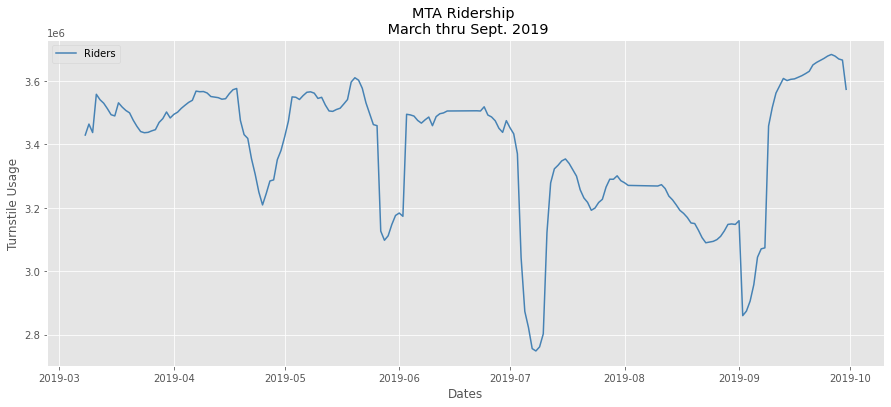

In [44]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(sum_per_date_2019['week_avg_2019'], color='steelblue', label='Riders')
ax.set_title('MTA Ridership \n March thru Sept. 2019')
ax.set_xlabel('Dates')
ax.set_ylabel('Turnstile Usage')
ax.legend()
plt.savefig('../img/ridership_2019', dpi=100)

In [45]:
sum_per_date_2020['week_avg_2020'] = sum_per_date_2020.iloc[:,2].rolling(window=7).mean()

In [46]:
min_2019 = sum_per_date_2019['Total'].min()
max_2019 = sum_per_date_2019['Total'].max()
print('Minimum Ridership in 1 Individual Day 2019: {0}'.format(min_2019))
print('Maximum Ridership in 1 Individual Day 2019: {0}'.format(max_2019))

Minimum Ridership in 1 Individual Day 2019: 1383826
Maximum Ridership in 1 Individual Day 2019: 4434472


In [47]:
min_2020 = sum_per_date_2020['Total'].min()
max_2020 = sum_per_date_2020['Total'].max()
print('Minimum Ridership in 1 Individual Day 2020: {0}'.format(min_2020))
print('Maximum Ridership in 1 Individual Day 2020: {0}'.format(max_2020))

Minimum Ridership in 1 Individual Day 2020: 147782
Maximum Ridership in 1 Individual Day 2020: 4153391


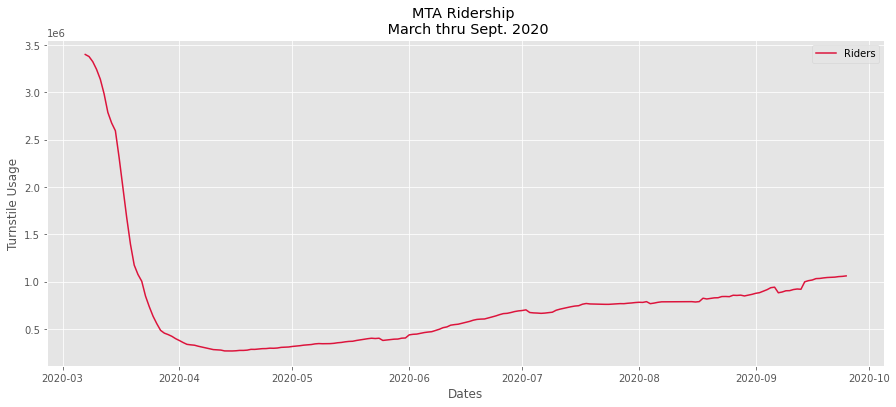

In [48]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(sum_per_date_2020['week_avg_2020'], color='crimson', label='Riders')
ax.set_title('MTA Ridership \n March thru Sept. 2020')
ax.set_xlabel('Dates')
ax.set_ylabel('Turnstile Usage')
ax.legend()
plt.savefig('../img/ridership_2020', dpi=100)

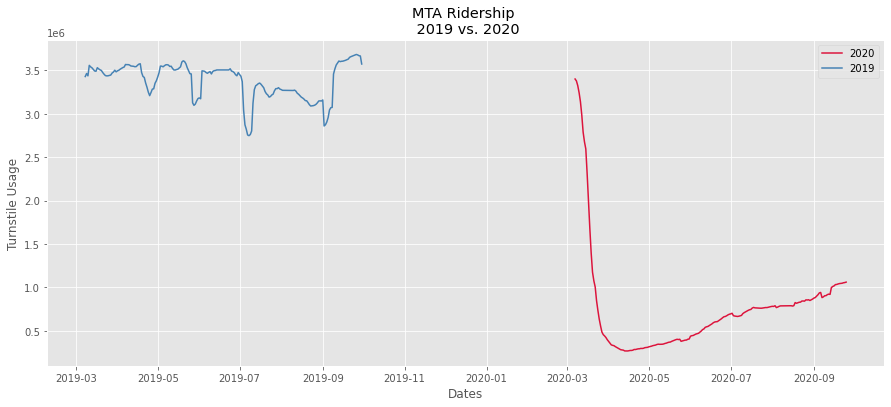

In [49]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(sum_per_date_2020['week_avg_2020'], color='crimson', label=2020)
ax.plot(sum_per_date_2019['week_avg_2019'], color='steelblue', label=2019)
ax.set_title('MTA Ridership \n 2019 vs. 2020')
ax.set_xlabel('Dates')
ax.set_ylabel('Turnstile Usage')
ax.legend()
plt.savefig('../img/ridership_2019_vs_2020', dpi=100)

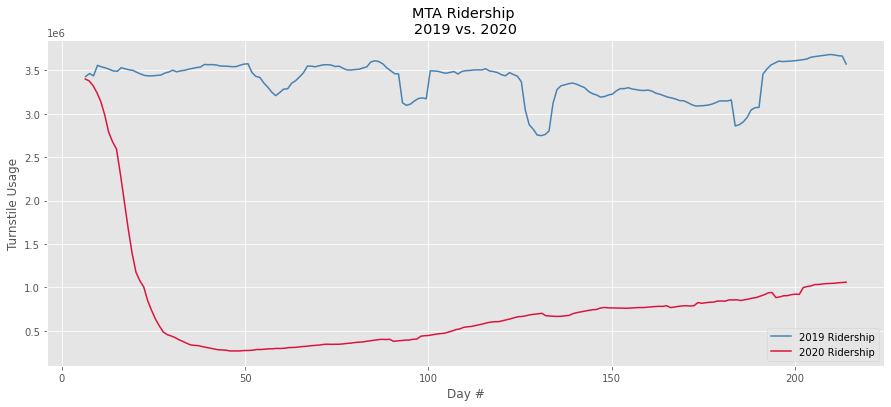

In [50]:
fig, ax = plt.subplots(figsize=(15,6))
x1 = np.linspace(0, 214, num=202)
x2 = np.linspace(0, 214, num=199)
ax.plot(x2, sum_per_date_2019['week_avg_2019'], color='steelblue', label='2019 Ridership')
ax.plot(x1, sum_per_date_2020['week_avg_2020'], color='crimson', label='2020 Ridership')

ax.set_title('MTA Ridership \n2019 vs. 2020')
ax.set_xlabel('Day #')
ax.set_ylabel('Turnstile Usage')
ax.legend()
plt.savefig('../img/ridership_2019_vs_2020_2', dpi=100)

In [51]:
stats.ttest_ind(sum_per_date_2019['week_avg_2019'].dropna(), sum_per_date_2020['week_avg_2020'].dropna(), equal_var=False )

Ttest_indResult(statistic=58.64397799046576, pvalue=1.1189989969861792e-145)

In [52]:
riders_per_station_2019 = sum_per_station_2019.groupby(level=[1]).sum()
riders_per_station_2019.reset_index()
riders_per_station_2019.drop([('Entries', 'max'), ('Entries', 'min')], axis=1, inplace=True)
riders_per_station_2019 = riders_per_station_2019.sort_values(by='Total', ascending = False).reset_index()

In [53]:
top5_riders_per_station_2019 = riders_per_station_2019[:5]
top5_riders_per_station_2019

,Station,Total
,,
0,14 ST-UNION SQ,15184519
1,FULTON ST,12399722
2,59 ST COLUMBUS,10628234
3,34 ST-PENN STA,10081790
4,TIMES SQ-42 ST,9871705


In [54]:
top5_sum_2019 = top5_riders_per_station_2019['Total'].sum()
top5_sum_2019

58165970

In [55]:
riders_per_station_2020 = sum_per_station_2020.groupby(level=[1]).sum()
riders_per_station_2020.reset_index()
riders_per_station_2020.drop([('Entries', 'max'), ('Entries', 'min')], axis=1, inplace=True)
riders_per_station_2020 = riders_per_station_2020.sort_values(by='Total', ascending = False).reset_index()

In [56]:
top5_riders_per_station_2020 = riders_per_station_2020[:5]
top5_riders_per_station_2020

,Station,Total
,,
0,14 ST-UNION SQ,2881147
1,FULTON ST,2396929
2,JKSN HT-ROOSVLT,2395646
3,FLUSHING-MAIN,2330032
4,59 ST COLUMBUS,1978491


In [57]:
# pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,
#          left_index=False, right_index=False, sort=True,
#          suffixes=('_x', '_y'), copy=True, indicator=False,
#          validate=None)
stations = pd.merge(riders_per_station_2019, riders_per_station_2020, on='Station')

/Users/thomasjoy/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [58]:
stations = stations.rename(columns={"Station": "Station", "Total_x": "2019", "Total_y": "2020"})
stations = stations.sort_values(by='2019', ascending = False)

In [59]:
stations_top5 = stations[:5]
stations_top5

,Station,2019,2020
,,,
0,14 ST-UNION SQ,15184519,2881147
1,FULTON ST,12399722,2396929
2,59 ST COLUMBUS,10628234,1978491
3,34 ST-PENN STA,10081790,1592581
4,TIMES SQ-42 ST,9871705,1630260


In [60]:
top5_sum_2020 = top5_riders_per_station_2020['Total'].sum()
top5_sum_2020

11982245

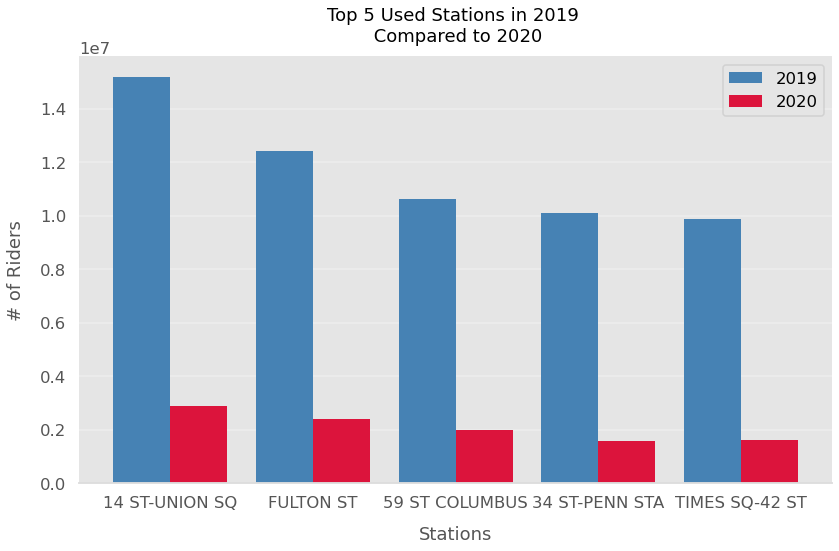

In [61]:
# Use Seaborn's context settings to make fonts larger.
import seaborn as sns
sns.set_context('talk')

# Create a grouped bar chart, with job as the x-axis
# and gender as the variable we're grouping on so there
# are two bars per job.
fig, ax = plt.subplots(figsize=(12, 8))

# Our x-axis. We basically just want a list
# of numbers from zero with a value for each
# of our jobs.
x = np.arange(len(stations_top5))

# Define bar width. We need this to offset the second bar.
bar_width = 0.4

b1 = ax.bar(x, stations_top5['2019'],
            width=bar_width, color='steelblue', label='2019')
# Same thing, but offset the x.
b2 = ax.bar(x + bar_width, stations_top5['2020'],
            width=bar_width, color="crimson", label='2020')

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(top5_riders_per_station_2019['Station'])

# Add legend.
ax.legend()

# Axis styling.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add axis and chart labels.
ax.set_xlabel('Stations', labelpad=15)
ax.set_ylabel('# of Riders', labelpad=15)
ax.set_title('Top 5 Used Stations in 2019 \n Compared to 2020', pad=15)

fig.tight_layout()

plt.savefig('../img/top5_stations', dpi=80)

In [62]:
#reverse geo coding
# try to predict ridership by zip of station based on income, covid cases